In [1]:
import os
root = os.getcwd()
print(root)

/Users/kinbunhua/cs521/group


Figure 1. Samples of Nasi from the data-set:

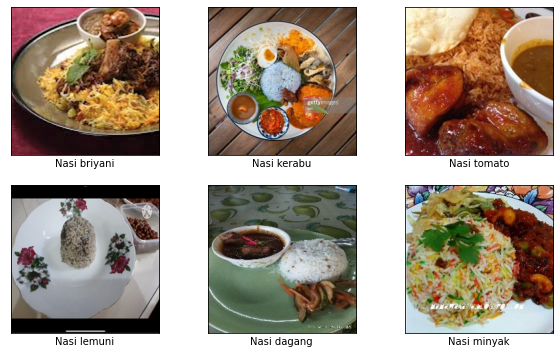

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

DATADIR = root + "/Nasi"

CATEGORIES = ["Nasi briyani", "Nasi kerabu", "Nasi tomato", "Nasi lemuni", "Nasi dagang", "Nasi minyak"]

plt.figure(figsize = (10, 6))
i = 0
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    i = i + 1
    plt.subplot(2, 3, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #print(path)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        #print(os.path.join(path,img))
        img_array = mpimg.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.xlabel(category)
        break  # we just want one for now so break
plt.show()  # display!

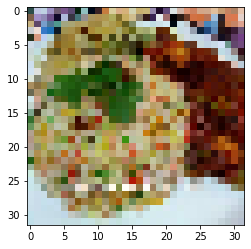

In [11]:
IMG_SIZE = 32

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [15]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 300/300 [00:00<00:00, 888.72it/s] 

1824


In [16]:
import random

random.shuffle(training_data)

In [17]:
X = []
y = []
channels = 3
num_classes = len(CATEGORIES)
INPUT_SIZE = IMG_SIZE * IMG_SIZE * channels
for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X.shape, y.shape)
#import train_test_split function
from sklearn.model_selection import train_test_split

#split the dataset into training and test sets 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
print(num_classes)
print(y[0])
print(y[1])

6
1
4


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#defines the options for augmentation 
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation 
    image : raw image 
    nb_augmentation: number of augmentations 
    images: array with new images 
    '''
    images = [] 
    image = image.reshape(1, IMG_SIZE, IMG_SIZE, channels)
    i = 0 
    for x_batch in datagen.flow(image, batch_size = 1):
        images.append(x_batch)
        i += 1 
        if i >= nb_of_augmentation:
            #interrupt augmentation 
            break 
    return images 

In [28]:
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
def create_model():
    model = VGG16(include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, channels))

    #add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(256, activation='relu')(flat1)
    class2 = Dense(256, activation='relu')(class1)
    class3 = Dense(256, activation='relu')(class2)
    output = Dense(num_classes, activation='softmax')(class3)

    #define new model
    model_new = Model(inputs = model.inputs, outputs = output)

    # make all layers untrainable by freezing weights (except for last layer)
    for l, layer in enumerate(model_new.layers[:-1]):
        layer.trainable = False

    # ensure the last layer is trainable/not frozen
    for l, layer in enumerate(model_new.layers[-1:]):
        layer.trainable = True

    model_new.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model_new 

In [29]:
create_model().summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [20]:
import tensorflow as tf 

def preprocess_data(images, targets, use_augmentation = False, nb_of_augmentation = 1):
    '''
    images : raw image 
    targets : target label
    use_augmentation : True if augmentation should be used 
    nb_of_augmentation : if use_augmentation = True, number of augmentations 
    '''
    X = []
    y = [] 
    for x_, y_ in zip(images, targets):
        #scaling pixels between 0.0-1.0 
        x_ = x_ / 255. 

        #data augmentation 
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(IMG_SIZE, IMG_SIZE, channels))
                y.append(y_)
        
        X.append(x_.reshape(IMG_SIZE, IMG_SIZE, channels))
        y.append(y_)

    print("*Preprocessiong completed:%i samples\n" % len(X))
    #print(X)
    firstargu = np.array(X)
    print(firstargu.shape)
    secondargu = tf.keras.utils.to_categorical(y)
    return firstargu, secondargu

In [21]:
nb_augmentation = 2 #defines the number of additional augmentations of one image
X_train_shaped, y_train_shaped = preprocess_data(
    X, y,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = preprocess_data(X_test, y_test)

*Preprocessiong completed:4377 samples

(4377, 32, 32, 3)
*Preprocessiong completed:365 samples

(365, 32, 32, 3)


In [30]:
from sklearn.model_selection import train_test_split 
histories = []
batch_size = 20
num_epochs = 80   #original 80  
iterations = 1   #original 5 number of iterations

for i in range(0, iterations):
    print('Running iteration:%i' % i)

    #saving the best checkpoint for each iteration 
    filepath = 'vgg_nasi-%i.hdf5' % i

    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped, test_size=0.2, random_state=42)

    vgg = create_model()
    history = vgg.fit(
        X_train_, y_train_,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val_, y_val_),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )
    histories.append(history.history)

Running iteration:0
Epoch 1/80
175/176 [============================>.] - ETA: 0s - loss: 1.7251 - accuracy: 0.3166
Epoch 1: val_loss improved from inf to 1.64629, saving model to vgg_nasi-0.hdf5
176/176 [==============================] - 39s 215ms/step - loss: 1.7251 - accuracy: 0.3165 - val_loss: 1.6463 - val_accuracy: 0.3881
Epoch 2/80
175/176 [============================>.] - ETA: 0s - loss: 1.5803 - accuracy: 0.4580
Epoch 2: val_loss improved from 1.64629 to 1.54887, saving model to vgg_nasi-0.hdf5
176/176 [==============================] - 38s 218ms/step - loss: 1.5804 - accuracy: 0.4579 - val_loss: 1.5489 - val_accuracy: 0.4395
Epoch 3/80
175/176 [============================>.] - ETA: 0s - loss: 1.4925 - accuracy: 0.4709
Epoch 3: val_loss improved from 1.54887 to 1.49602, saving model to vgg_nasi-0.hdf5
176/176 [==============================] - 38s 215ms/step - loss: 1.4924 - accuracy: 0.4710 - val_loss: 1.4960 - val_accuracy: 0.4395
Epoch 4/80
175/176 [======================

In [31]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	1.00520563 loss / 0.63924593 acc
Validation: 	1.09471214 loss / 0.59474885 acc


In [33]:
test_loss = []
test_accs = []

for i in range(0, iterations): 
    cnn_ = tf.keras.models.load_model("vgg_nasi-%i.hdf5" % i)
    
    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

running final test with model 0: 1.1531 loss / 0.5808 acc

Average loss / accuracy on testset: 1.1531 loss / 0.58082 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


In [35]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #accuracy 
    ax1.set_title("Model accuracy (%s)" % title)

    names = []

    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append("Model %i" % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')

    #Loss 
    ax2.set_title("model loss (%s)" % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc = 'upper right')
    fig.set_size_inches(20, 5)
    plt.show()

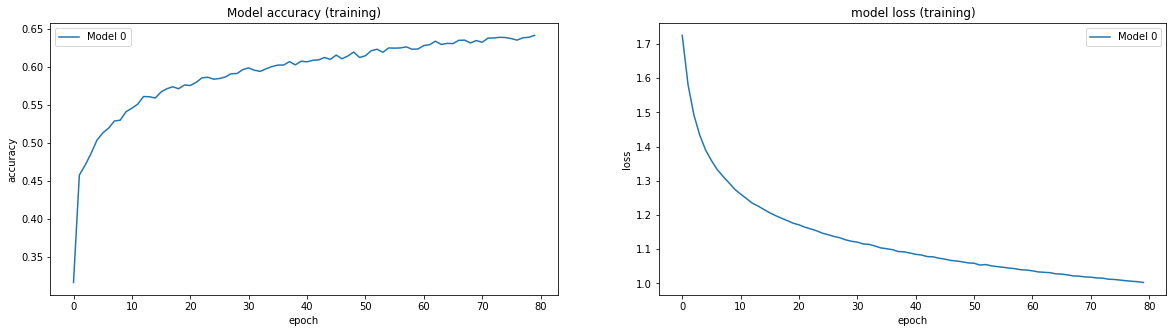

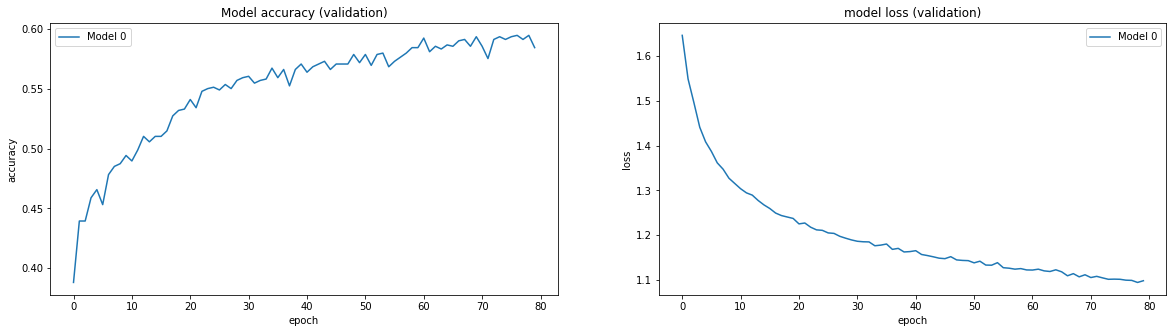

In [36]:
plot_acc_loss("training", histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

In [38]:
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights("vgg_nasi-%i.hdf5" % RUN)

In [39]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #Accuracy 
    ax1.set_title("Model accuracy - %s" % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    #loss 
    ax2.set_title("model loss - %s" % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc = 'upper left')

    fig.set_size_inches(20,5)
    plt.show()

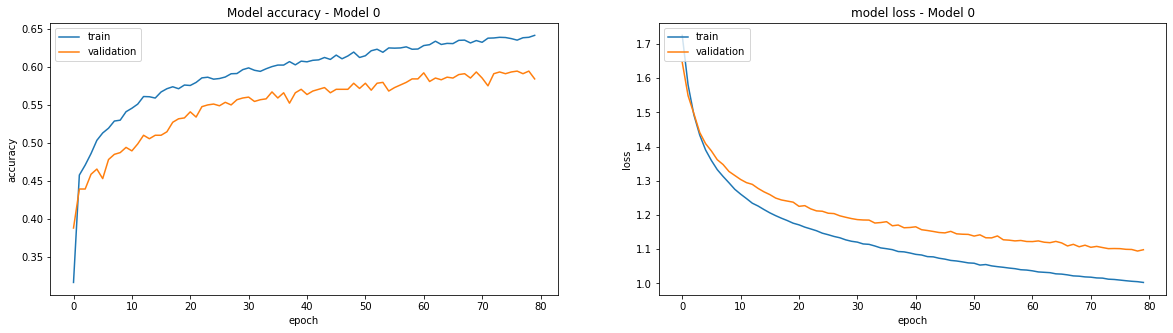

In [40]:
plot_train_val("Model %i" % RUN, histories[RUN])

In [41]:
import numpy as np 
a = np.arange(6).reshape(2, 3)

b = np.argwhere(a > 1)
print(b)

[[0 2]
 [1 0]
 [1 1]
 [1 2]]


In [48]:
def plot_sample_predictions(classes, model, X_test, y_test):
    '''
    this function displays images randomly and tries to predict the correct class
    '''

    class_ = 0
    images_per_row = 3 
    rows = int(len(classes) / images_per_row)  #image_per_row
    #print(rows, X_test, y_test)
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)
        #print(axis)
        for i, axis in enumerate(axis):
            #print(class_, i, axis)
            elements = np.squeeze(np.argwhere(y_test == class_))
            len_e = len(elements) 
            random = np.random.randint(len_e)
            #print(random, elements, elements[random])
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(12, 24)

            x_reshape = X.reshape([1, IMG_SIZE, IMG_SIZE, channels])
            axis.text(0, 34, 'Predicted:{}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0, 38, 'Correct:{}'.format(classes[y]))
            axis.imshow(np.squeeze(X), cmap = 'gray')
            
            axis.axis('off')
            class_ += 1
    plt.show()

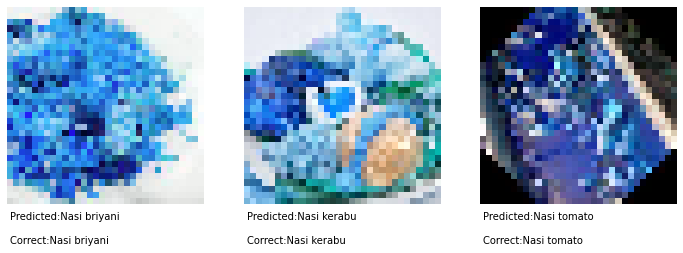

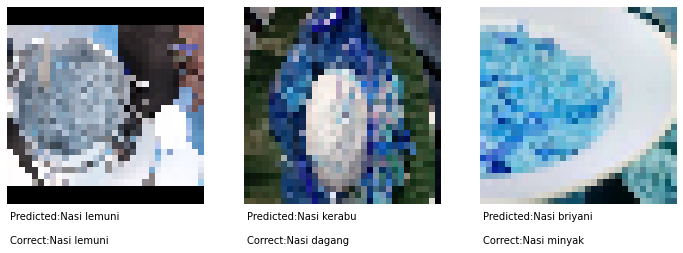

In [49]:
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))

In [50]:
from sklearn.metrics import confusion_matrix
import itertools 

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap = plt.cm.Reds):
    '''
    this function plots a confusion matrix
    '''
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                horizontalalignment = 'center',
                color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

[4 5 2 1 3 3 0 0 5 4 2 1 0 3 3 2 1 4 2 3 5 5 4 5 1 0 2 2 4 2 3 3 1 0 3 0 0
 4 2 2 4 3 5 2 0 3 5 4 3 5 2 2 5 0 2 2 3 2 5 1 5 3 5 1 2 1 1 0 4 2 1 2 1 3
 3 5 0 3 1 5 3 5 1 0 0 2 4 2 4 3 0 2 3 0 0 1 3 0 1 4 3 3 2 3 5 3 1 1 4 1 2
 2 5 1 1 1 1 3 0 4 1 1 4 4 2 4 1 0 0 5 1 1 5 1 3 1 4 4 1 1 3 5 0 0 3 4 3 5
 5 4 1 0 2 3 0 4 4 1 3 5 1 0 0 3 2 5 0 4 5 3 4 1 2 3 5 0 0 3 2 2 3 1 2 2 2
 1 1 0 1 4 1 0 0 2 1 2 3 5 5 1 3 3 5 1 0 4 3 1 5 4 2 3 3 1 3 3 3 0 1 4 1 0
 3 5 1 5 0 1 4 1 0 4 4 3 3 2 2 3 5 0 1 1 3 2 0 0 0 4 3 5 2 5 5 5 4 1 3 5 0
 3 0 3 2 0 4 0 1 1 2 1 3 2 0 4 2 1 1 4 3 0 3 2 2 4 2 0 2 1 0 5 1 3 5 1 4 5
 4 1 1 3 1 0 5 3 3 5 1 0 2 0 1 4 5 1 0 2 5 3 1 4 3 1 4 1 3 3 0 3 1 1 4 0 5
 2 2 3 1 4 0 1 1 3 1 0 0 1 0 0 5 0 5 5 4 0 1 4 0 1 3 2 3 4 1 1 2]


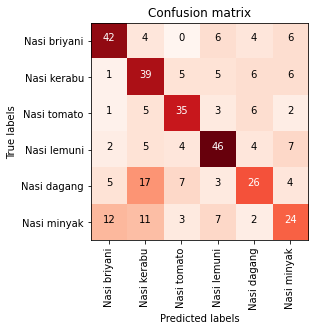

In [51]:
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
print(predictions)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67        62
           1       0.48      0.63      0.55        62
           2       0.65      0.67      0.66        52
           3       0.66      0.68      0.67        68
           4       0.54      0.42      0.47        62
           5       0.49      0.41      0.44        59

    accuracy                           0.58       365
   macro avg       0.58      0.58      0.58       365
weighted avg       0.58      0.58      0.58       365

